# SMfit tool
The tool whose aim is to facilitate the fitting of the (experimental) curve with multiple (overlapping) peaks.

<div class="alert alert-block alert-danger">
    <details>
        <summary><b>Baseline !</b> </summary>   
    Your curve should be baseline-corrected.
    If that is not the case, you may want to use the `baseline_als` function
    to remove the baseline first. You'll find this function in `utilities.py`.
    You can find the instructions on how to do that <a href="./baseline_correction.md">here</a>
    </details>
</div>
This procedure allows you to manually determine reasonable initial parameters to pass on to scipy optimize module.

## **Instructions:** 
1. Left-click on the graph to add one pseudo-voigt profile at a time.
    -  Once the profile added, you can modify its width by scrolling the mouse wheel.
2. Repeat the procedure as many times as needed to account for all the peaks you beleive are present.
- Right-clicking any time will draw the sum of all the present profiles you added up to that moment.
- Left clicking on the top of existing peak erases it.



<details>
    <summary> Imports: </summary>
    <pre>    
        <code class="language-python">
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.patches import Ellipse
        from copy import copy
        from scipy.optimize import curve_fit
        from utilities import fitonclick, pV
        from utilities import multi_pV as fitting_function
        plt.style.use('bmh')
        </code>
    </pre>
</details>

### Let's create some artificial data:
<div class="alert alert-block alert-info">
    <details>
    <summary>Load your data </summary>
    You should replace this block by loading your own data</ br>
    as 1D numpy arrays of shape ("length of data", )</ br>
    For example: </ br>
    >>> x, y = np.loadtxt("your_file_containing_data.txt")
    </details>
</div>

```python
dummy_params = [51, 200, 85, 0.3,
                10, 272, 37, 0.8,
                2.7, 317, 39, 0.52,
                3.9, 471, 62, 0.25]

x = np.arange(0, 584, 1.34)
y = fitting_function(x, *dummy_params)  # Multiple pseudo-voigt
# Add some noise to the data:
y += np.random.random(len(x))*np.mean(y)/5
```

### Now we plot the data, and then interactively (oh yes!) assign the initial values to the fitting procedure.
<div class="alert alert-block alert-warning">
<details>
    <summary>Attention!</summary>
    This step is very important. You should be aware that there could be <b>many</b> different combinations of peaks that can fit you data equally well. This is why your expert (yes, that's you) input is important. Other thing of paramount importance is to set the limits on the fitting parameters (restrain the space whithin which the algorithm searches for a minimum).
</details>
</div>

![](pics/SMfit_in_action.gif)

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from copy import copy
from scipy.optimize import curve_fit
import utilities as ut

fitting_function = ut.multi_pV
# from utilities import fitonclick, pV, set_bounds, set_size
# from utilities import multi_pV as fitting_function
# plt.style.use('bmh')

Here, we'll create some artificial data:
<div class="alert alert-block alert-info">
    You should replace this block by loading your own data</ br>
    in form of x and y as numpy arrays of shape ("length of data", )</ br>
    For example: </ br>
    >>> x, y = np.loadtxt("your_file_containing_data.txt")
</div>

In [2]:
dummy_params = [51, 200, 85, 0.3,
                10, 272, 37, 0.8,
                2.7, 317, 39, 0.52,
                3.9, 471, 62, 0.25]

x = np.arange(0, 584, 1.34)
y = fitting_function(x, *dummy_params)
# Add some noise to the data:
y += np.random.random(len(x))*np.mean(y)/5

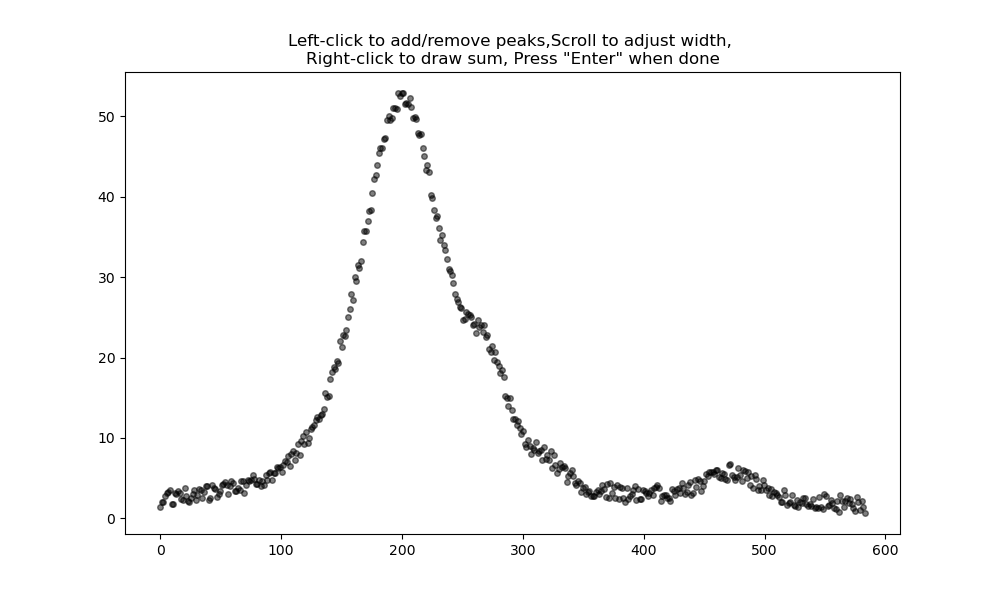

In [3]:
# check the docstring for the fitonclick class:
# del mfit
mfit = ut.fitonclick(x, y, scrolling_speed=4, figsize=(10, 6))

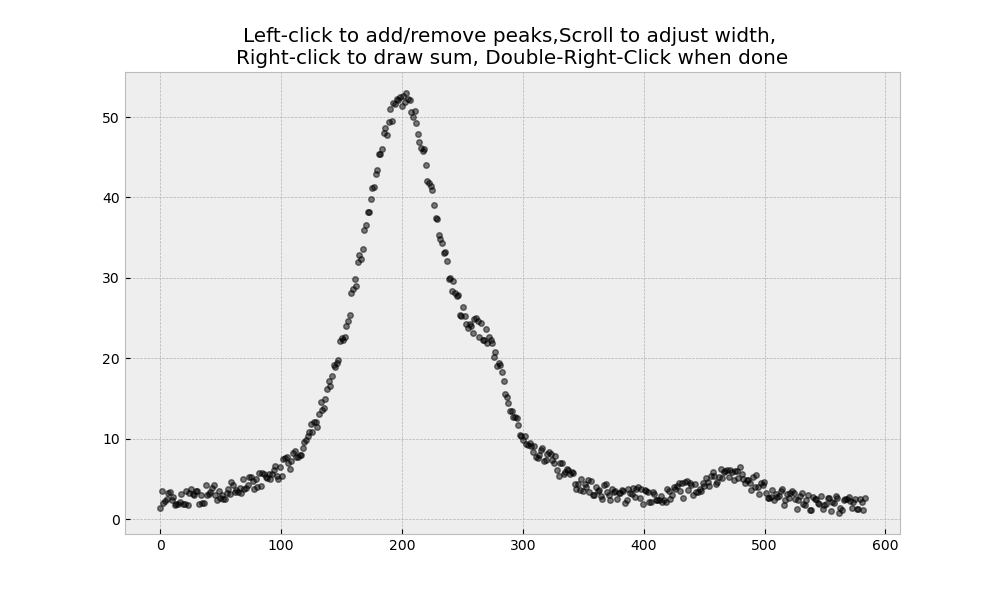

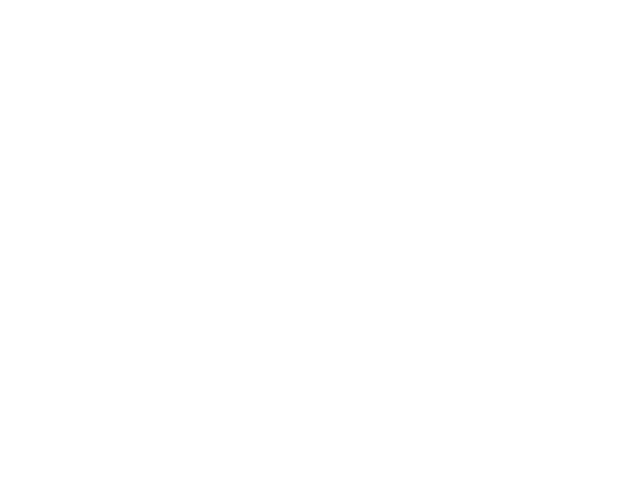

KeyboardInterrupt: 

In [3]:
# Important:
while mfit.block:
    plt.waitforbuttonpress(timeout=-1)
plt.close()  # Optional (you can also leave the plot on if you want)

In [36]:
x_size = mfit.x_size
peaks_present: int = mfit.peak_counter
pic = mfit.pic
# creating the list of initial parameters from your manual input:
# (as a list of lists)
manualfit_components_params = np.array(pic['h'] + pic['x0'] + pic['w'] + 
                                       pic['GL']).reshape(peaks_present, -1).T
# # to transform the list of lists into one single list:
mfcp = manualfit_components_params.ravel()
# manualfit_components_params = list(chain(*manualfit_components_params))

# the sum of manually created peaks:
if len(mfit.sum_peak) == 1:
    manualfit = mfit.sum_peak[0][0].get_ydata()
else:
    manualfit = fitting_function(x, *mfcp)

In [38]:
bounds = ut.set_bounds(manualfit_components_params,
                       A=(0.5, 1.4, "multiply"),
                       x=(-2*x_size, 2*x_size, "add"),
                       w=(0.5, 16, "multiply"),
                       gl=(0, 1, "absolute"))

0 (0.5, 1.4, 'multiply') <ufunc 'multiply'>
1 (-16.654285714285717, 16.654285714285717, 'add') <ufunc 'add'>
2 (0.5, 16, 'multiply') <ufunc 'multiply'>
3 (0, 1, 'absolute') <function set_bounds.<locals>.func at 0x7f229ff56ee0>


In [39]:
# Setting the bounds based on your input
# (you can play with this part if you feel like it,
# but leaving it as it is should be ok for basic usage)
def set_bounds(initial_params,
               A=(0.5, 1.4, "multiply"),
               x=(-2*x_size, 2*x_size, "add"),
               w=(0.5, 16, "multiply"),
               gl=(0, 1, "absolute")):
    """Define the bounds based on the initial parameters.
    
    Parameters:
    -----------
    initial_params: list of lists or a 2D numpy array
        ! Warning: the order is important
        for the pseudo-voigt as defined in utilities.py `pV` function it is:
        [[A_1, x_1, w_1, gl_1],
         [A_2, x_2, ....],
         ...
         [A_N, x_N, w_N, gl_N]]
        where N is the number of peaks, and for each peak:
            A: amplitude
            x: position
            w: width (at mid-height)
            gl: gaussian to lorentzian ratio (from 0 to 1)
    A, x, w, gl: tuples of form (lower: float, upper: float, method: str)
        Bounds relative to the initial_params.
        method can be one of ["multiply", "add", "absolute"]
        "multiply": the bounds for the given parameter are in the range
                    (param * lower, param * upper)
        "add":      the bounds for the given parameter are in the range
                    (param - lower, param + upper)
        "absolute": the bounds for the given parameter are in the range
                    (lower, upper)
    
    Returns:
    --------
    bounds: tuple of type (lower_bounds, upper_bounds)
        where lower_bounds and upper_bounds are 1D numpy arrays of lengths
        equal to N * n_params.
            N: number of peaks
            n_params: number of parameters needed to define one peak
        """
    # set the initial bounds as infinities:
    upper_bounds = np.ones_like(initial_params)*np.inf
    lower_bounds = np.ones_like(initial_params)*(-np.inf)
    for i, p in enumerate([A, x, w, gl]):
        if p[-1] == "multiply":
            func = np.multiply
        elif p[-1] == "add":
            func = np.add
        else:
            def func(mp, p):
                return p
        print(i, p, func)
        lower_bounds[:, i] = np.asarray([func(mp[i], p[0]) for mp in initial_params])
        upper_bounds[:, i] = np.asarray([func(mp[i], p[1]) for mp in initial_params])
        
    return (lower_bounds.ravel(), upper_bounds.ravel())
            

# set the initial bounds as infinities:
upper_bounds = np.ones_like(manualfit_components_params)*np.inf
lower_bounds = np.ones_like(manualfit_components_params)*(-np.inf)

# setting reasonable bounds for the peak amplitude
# as a portion to your initial manual estimate
upper_bounds[:, 0] = np.asarray([A[0]*1.4 for A in manualfit_components_params])
lower_bounds[:, 0] = np.asarray([A[0]*0.5 for A in manualfit_components_params])

# setting reasonable bounds for the peak position
# as a shift in regard to your initial manual position
upper_bounds[:, 1] = \
    np.asarray([A[1] + 2*x_size for A in manualfit_components_params])
lower_bounds[:, 1] = \
    np.asarray([A[1] - 2*x_size for A in manualfit_components_params])

# setting the bounds for the widths
upper_bounds[:, 2] = \
    np.asarray([A[2]*16 for A in manualfit_components_params])
lower_bounds[:, 2] = \
    np.asarray([A[2]*0.5 for A in manualfit_components_params])


# setting the bounds for the lorentz/gauss ratio
upper_bounds[:, 3] = 1
lower_bounds[:, 3] = 0


bounds = (lower_bounds.ravel(), upper_bounds.ravel())


In [40]:
bounds

(array([ 22.44970573, 180.93916478,  20.81785714,   0.        ,
          9.81935177, 223.96094542,  20.81785714,   0.        ,
          2.95103013, 279.3928551 ,  20.81785714,   0.        ,
          2.75435484, 455.61668736,  20.81785714,   0.        ]),
 array([ 62.85917603, 214.24773621, 666.17142857,   1.        ,
         27.49418496, 257.26951685, 666.17142857,   1.        ,
          8.26288437, 312.70142653, 666.17142857,   1.        ,
          7.71219356, 488.92525879, 666.17142857,   1.        ]))

In [41]:
bounds2 = ut.set_bounds(manualfit_components_params,
                       A=(0.5, 1.4, "multiply"),
                       x=(-2*x_size, 2*x_size, "add"),
                       w=(0.5, 16, "multiply"),
                       gl=(0, 1, "absolute"))

0 (0.5, 1.4, 'multiply') <ufunc 'multiply'>
1 (-16.654285714285717, 16.654285714285717, 'add') <ufunc 'add'>
2 (0.5, 16, 'multiply') <ufunc 'multiply'>
3 (0, 1, 'absolute') <function set_bounds.<locals>.func at 0x7f229fabbb80>


In [42]:
bounds2

(array([ 22.44970573, 180.93916478,  20.81785714,   0.        ,
          9.81935177, 223.96094542,  20.81785714,   0.        ,
          2.95103013, 279.3928551 ,  20.81785714,   0.        ,
          2.75435484, 455.61668736,  20.81785714,   0.        ]),
 array([ 62.85917603, 214.24773621, 666.17142857,   1.        ,
         27.49418496, 257.26951685, 666.17142857,   1.        ,
          8.26288437, 312.70142653, 666.17142857,   1.        ,
          7.71219356, 488.92525879, 666.17142857,   1.        ]))

In [20]:
# The curve-fitting part:
fitted_params, b = curve_fit(fitting_function, x, y, method='trf',
                             p0=mfcp,
                             absolute_sigma=False, bounds=bounds)

In [21]:
fitting_err = np.sqrt(np.diag(b))

y_fitted = fitting_function(x, *fitted_params)

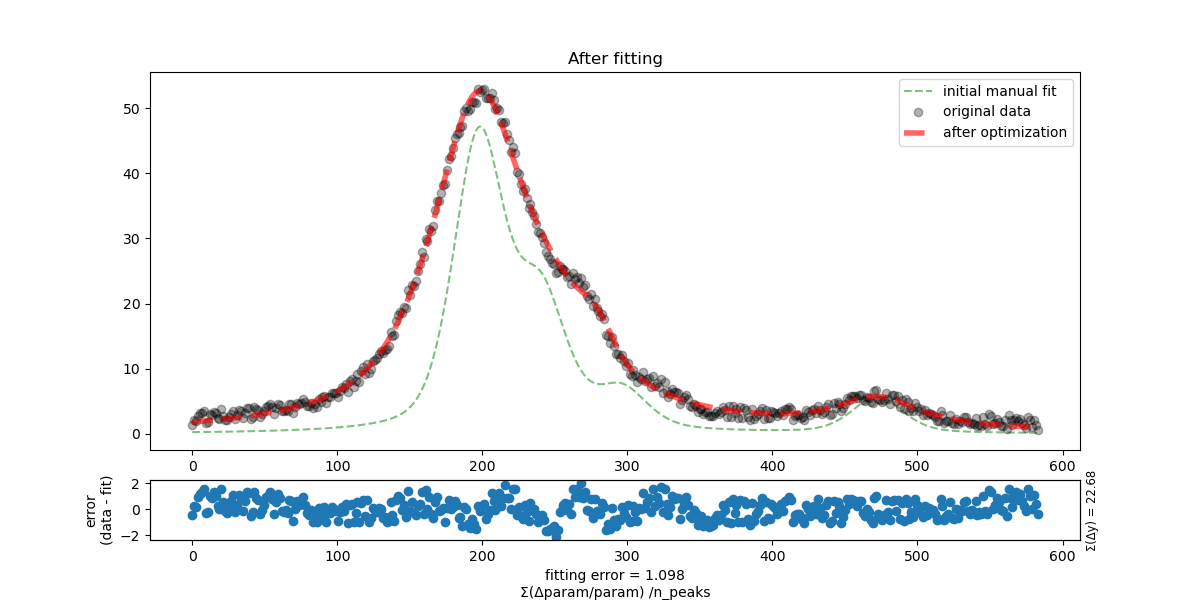

In [22]:
# Plotting the results of the optimization:
figg, axx, = plt.subplots(figsize=(12, 6))
figg.subplots_adjust(bottom=0.25)
errax = figg.add_axes([0.125, 0.1, 0.775, 0.1])
errax.set_facecolor('w')

axx.plot(x, manualfit,
         '--g', alpha=0.5, label='initial manual fit')

axx.plot(x, y, linestyle='none', marker='o', c='k',
         alpha=0.3, label='original data')

axx.plot(x, y_fitted,
         '--r', lw=4, alpha=0.6, label='after optimization')

axx.legend()

errax.plot(x, y-y_fitted, linestyle='none', marker='o')
errax.set_ylabel('error\n(data - fit)')
errax.set_xlabel(f'fitting error = '
                 f'{np.sum(fitting_err/np.ceil(fitted_params))/peaks_present:.3f}'
                 f'\n\u03A3(\u0394param/param) /n_peaks')
errax2 = errax.twinx()
errax2.set_yticks([])
errax2.set_ylabel(f'\u03A3(\u0394y) = {np.sum(y-y_fitted):.2f}',
                  fontsize='small')
axx.set_title('After fitting')
plt.show(block=False)


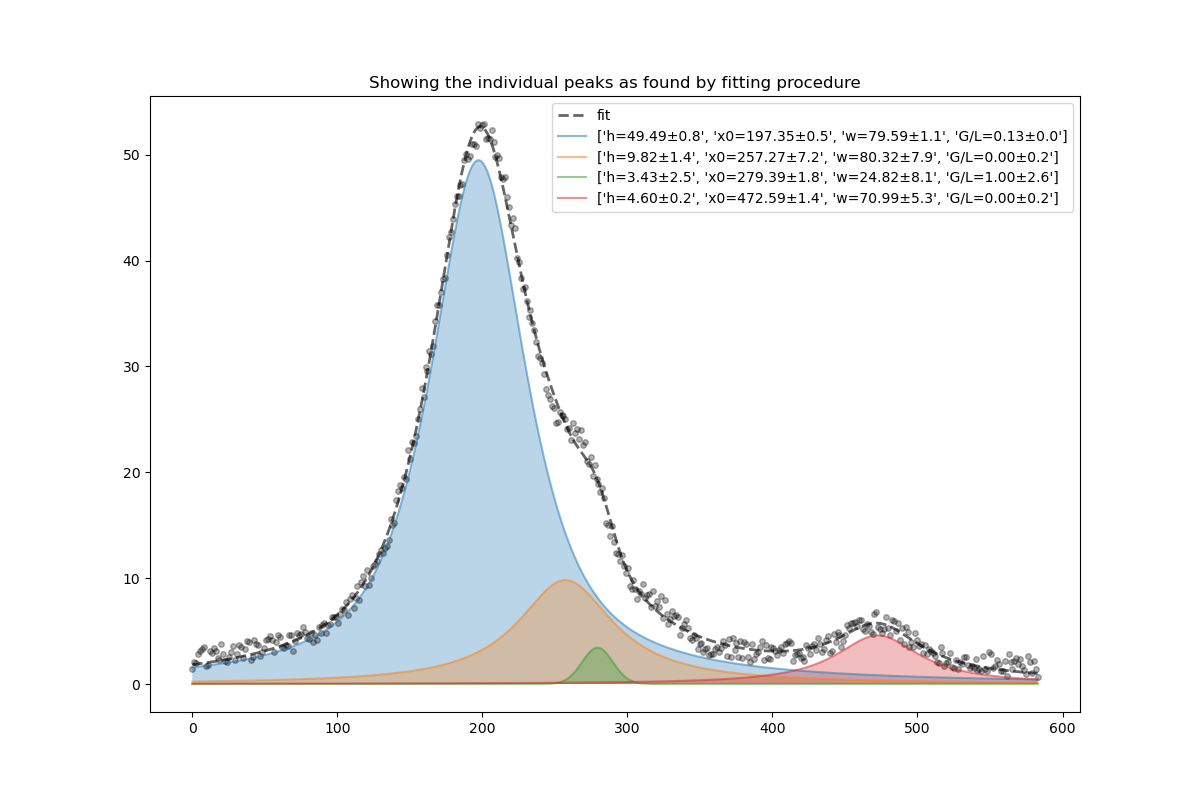

                             Your initial guess      After fitting

Peak 0|   Height              :     44.90     ->      49.49 ± 0.81
Peak 0|   Center              :    197.59     ->     197.35 ± 0.53
Peak 0|   FWMH                :     41.64     ->      79.59 ± 1.12
Peak 0|   Ratio Gauss/Lorenz  :      0.50     ->       0.13 ± 0.02
Peak 1|   Height              :     19.64     ->       9.82 ± 1.44
Peak 1|   Center              :    240.62     ->     257.27 ± 7.18
Peak 1|   FWMH                :     41.64     ->      80.32 ± 7.92
Peak 1|   Ratio Gauss/Lorenz  :      0.50     ->       0.00 ± 0.20
Peak 2|   Height              :      5.90     ->       3.43 ± 2.47
Peak 2|   Center              :    296.05     ->     279.39 ± 1.79
Peak 2|   FWMH                :     41.64     ->      24.82 ± 8.13
Peak 2|   Ratio Gauss/Lorenz  :      0.50     ->       1.00 ± 2.65
Peak 3|   Height              :      5.51     ->       4.60 ± 0.20
Peak 3|   Center              :    472.27     ->     472.59 ±

In [24]:
figsize=(12,8)# Plotting the individual peaks after fitting
pfig, pax = plt.subplots(figsize=figsize)

pax.plot(x, y, linestyle='none', marker='o', ms=4, c='k', alpha=0.3)
pax.plot(x, y_fitted,
         '--k', lw=2, alpha=0.6, label='fit')
par_nam = ['h', 'x0', 'w', 'G/L']
for i in range(peaks_present):
    fit_res = list(zip(par_nam, fitted_params[i*4:i*4+4],
                       fitting_err[i*4:i*4+4]))
    label = [f"{P}={v:.2f}\U000000B1{e:.1f}" for P, v, e in fit_res]
    yy_i = ut.pV(x, *fitted_params[i*4:i*4+4])
    peak_i, = pax.plot(x, yy_i, alpha=0.5, label=label)
    pax.fill_between(x, yy_i, facecolor=peak_i.get_color(), alpha=0.3)
pax.legend()
pax.set_title('Showing the individual peaks as found by fitting procedure')

pfig.show()
parametar_names = ['Height', 'Center', 'FWMH', 'Ratio Gauss/Lorenz']
print(f"{'Your initial guess':>47s}{'After fitting':>19s}\n")
for i in range(len(fitted_params)):
    print(f"Peak {i//4}|   {parametar_names[i%4]:<20s}: "
          f" {mfcp[i]:8.2f}     ->    "
          f" {fitted_params[i]:6.2f} \U000000B1 {fitting_err[i]:4.2f}")

In [ ]:
# Deleting the class instance, in case you want to start over
del mfit